# RNA-seq analysis.

* Data:
`data/SRR453566_*.fastq`
* Genome:
`data/ref.fa`
* Base of genes:
`data/genes.gtf`


### 1. Выравнивание ридов RNA-Seq
Приложить риды RNA-Seq на геном (можно с использованием базы генов) с помощью программ HISAT2 или STAR (на выбор).


In [12]:
!hisat2-build -p 8 data/ref.fa data/index

Settings:
  Output files: "data/index.*.ht2"
  Line rate: 6 (line is 64 bytes)
  Lines per side: 1 (side is 64 bytes)
  Offset rate: 4 (one in 16)
  FTable chars: 10
  Strings: unpacked
  Local offset rate: 3 (one in 8)
  Local fTable chars: 6
  Local sequence length: 57344
  Local sequence overlap between two consecutive indexes: 1024
  Endianness: little
  Actual local endianness: little
  Sanity checking: disabled
  Assertions: disabled
  Random seed: 0
  Sizeofs: void*:8, int:4, long:8, size_t:8
Input files DNA, FASTA:
  data/ref.fa
Reading reference sizes
  Time reading reference sizes: 00:00:00
Calculating joined length
Writing header
Reserving space for joined string
Joining reference sequences
  Time to join reference sequences: 00:00:00
  Time to read SNPs and splice sites: 00:00:00
Using parameters --bmax 2279457 --dcv 1024
  Doing ahead-of-time memory usage test
  Passed!  Constructing with these parameters: --bmax 2279457 --dcv 1024
Constructing suffix-array element generat

In [15]:
!hisat2 -p 8 -x data/index -1 data/SRR453566_1.fastq -2 data/SRR453566_2.fastq | samtools sort > data/out.bam

5725730 reads; of these:
  5725730 (100.00%) were paired; of these:
    1205178 (21.05%) aligned concordantly 0 times
    4286523 (74.86%) aligned concordantly exactly 1 time
    234029 (4.09%) aligned concordantly >1 times
    ----
    1205178 pairs aligned concordantly 0 times; of these:
      136556 (11.33%) aligned discordantly 1 time
    ----
    1068622 pairs aligned 0 times concordantly or discordantly; of these:
      2137244 mates make up the pairs; of these:
        1449781 (67.83%) aligned 0 times
        637418 (29.82%) aligned exactly 1 time
        50045 (2.34%) aligned >1 times
87.34% overall alignment rate
[bam_sort_core] merging from 4 files and 1 in-memory blocks...


### 2. Оценка количества экспрессирующихся генов
По полученному SAM файлу и базе генов оценить процент экспрессирующихся генов. Какая часть гена должна быть покрыта и какая глубина должна быть чтобы он считался таковым, решите сами. Можно взять, к примеру, 95%. Глубину (экспрессию) лучше всего мерить в величинах FPKM или TPM.

* FPKM (Fragments Per Kilobase Million)
* TPM (Transcripts Per Million)

https://www.rna-seqblog.com/rpkm-fpkm-and-tpm-clearly-explained/

https://haroldpimentel.wordpress.com/2014/05/08/what-the-fpkm-a-review-rna-seq-expression-units/


In [25]:
!featureCounts -a data/genes.gtf -o data/quantifying data/out.bam


        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v1.6.0

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 1 BAM file                                       ||
||                           P data/out.bam                                   ||
||                                                                            ||
||             Output file : data/quantifying                                 ||
||                 Summary : data/quantifying.summary            

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
data = pd.read_csv('data/quantifying', sep='\t', skiprows=1)
data.head()

,Geneid,Chr,Start,End,Strand,Length,data/out.bam
0,YDL248W,IV,1802,2953,+,1152,584
1,YDL247W-A,IV,3762,3836,+,75,10
2,YDL247W,IV,5985,7814,+,1830,18
3,YDL246C,IV,8683,9756,-,1074,15
4,YDL245C,IV,11657,13360,-,1704,42


data/out.bam - покрытие

In [3]:
data.rename(columns={'data/out.bam': 'coverage'}, inplace=True)
data.head()

,Geneid,Chr,Start,End,Strand,Length,coverage
0,YDL248W,IV,1802,2953,+,1152,584
1,YDL247W-A,IV,3762,3836,+,75,10
2,YDL247W,IV,5985,7814,+,1830,18
3,YDL246C,IV,8683,9756,-,1074,15
4,YDL245C,IV,11657,13360,-,1704,42


In [4]:
data['fpkm'] = data['coverage']/(data['coverage'].sum()/10**6)/(data['Length']/10**3)
data['tpm'] =  data['coverage']/(data['Length']/10**3)
data['tpm'] /= (data['tpm'].sum()/10**6)
data.head() 

,Geneid,Chr,Start,End,Strand,Length,coverage,fpkm,tpm
0,YDL248W,IV,1802,2953,+,1152,584,58.936440,49.905016
1,YDL247W-A,IV,3762,3836,+,75,10,15.501091,13.125703
2,YDL247W,IV,5985,7814,+,1830,18,1.143523,0.968290
3,YDL246C,IV,8683,9756,-,1074,15,1.623718,1.374899
4,YDL245C,IV,11657,13360,-,1704,42,2.865519,2.426406


Так как TPM используется для сравнения разных сэмплов, а у нас по сути 1 сэмпл. Возьму FPKM. 

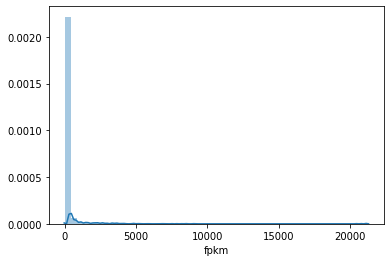

In [5]:
sns.distplot(data.fpkm)

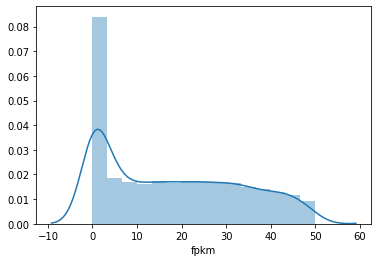

In [6]:
sns.distplot(data[data.fpkm<50].fpkm)

Возьму трешхолд = 5, так как вот меньше его есть пик, а дальше все +- ок

In [7]:
good_fpkm = 5
print(f'Хорошо экспрессируется {data[data.fpkm>good_fpkm].shape[0]/data.shape[0]*100}% генов;\nКоличественно: {data[data.fpkm>good_fpkm].shape[0]} из {data.shape[0]}')

Хорошо экспрессируется 81.43418467583497% генов;
Количественно: 5803 из 7126


### 3. Сборка de novo
Соберите риды с нуля любым RNA-Seq сборщиком (например Trinity или rnaSPAdes), запустите на полученных контигах rnaQUAST. Сравните количество покрытых генов с результатом, полученным в задании 2.

`rnaspades -t 1 -m 8 -1 data/SRR453566_1.fastq -2 data/SRR453566_2.fastq -o data/rna_assembling`

`rnaquast -t 8 --transcripts data/rna_assembling/transcripts.fasta --reference data/ref.fa --gtf data/genes.gtf`

Отчет по сборке лежат в папке `quast_reports/`

![](quast_reports/report.png)


Что видим? Генов столько же - 7126. Найдено транскриптов 6264, похоже на то число, какое у нас было в пунктике выше. Если убрать сильно мелкие, то получится лучше (например, >500 оснований их уже 4600).
Но если посмотреть по покрытым генам, то тут поменьше их количество. Переделаю немножко пункт 2, учитывая покрытие:

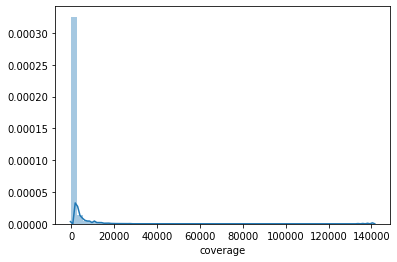

In [8]:
sns.distplot(data.coverage)

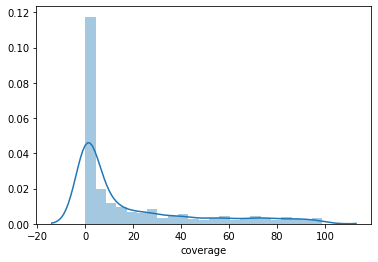

In [9]:
sns.distplot(data.coverage[data.coverage<100])

Сделаю еще трешхолд на покрытие 50:

In [10]:
good_fpkm = 5
good_cov = 50
print(f'Хорошо экспрессируется {data[(data.fpkm > good_fpkm) & (data.coverage > good_cov)].shape[0]/data.shape[0]*100}% генов;\nКоличественно: {data[(data.fpkm > good_fpkm) & (data.coverage > good_cov)].shape[0]} из {data.shape[0]}')

Хорошо экспрессируется 76.41032837496492% генов;
Количественно: 5445 из 7126


Поменьше, но больше, чем выдал quast.



...the end...